## with PreprocessMask

In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm as tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.losses import binary_crossentropy
from keras import backend as K
import segmentation_models as sm
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import generic_utils
from segmentation_models.losses import CategoricalFocalLoss
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
# from keras.optimizers import Adam,SGD
from keras.losses import BinaryCrossentropy
from keras.metrics import MeanIoU
from glob import glob

2024-03-18 17:42:08.942841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 17:42:09.476783: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 17:42:10.314873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/agrograde/anaconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/agrograde/anaconda3/envs/tf/lib/
2024-03-18 17:42:10.314998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Segmentation Models: using `keras` framework.


In [2]:
 print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-03-18 17:42:12.110777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 17:42:12.155626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 17:42:12.155883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:

def preprocessMasks(mask,height,width):
    mask_resized = cv2.threshold(cv2.resize(mask, (height,width)), 50, 1, cv2.THRESH_BINARY)[1]
    mask_data = np.zeros((height,width,2))
    
    for i in range(height):
        for j in range(width):


            #for segmentation mask
            if mask_resized[i,j]> 0:
                mask_data[i,j,1] = 1
            else:
                mask_data[i,j,0] = 1
                
    return mask_data       #output from the function(height, width, 2)

In [4]:
def load_data(path):
    images = sorted(glob(os.path.join(image_path, 'images/*')))
    sprout = sorted(glob(os.path.join(image_path, 'Sprout/*')))
    peeled = sorted(glob(os.path.join(image_path, 'Peeled/*')))
    rotten = sorted(glob(os.path.join(image_path, 'Rotten/*')))
    double = sorted(glob(os.path.join(image_path, 'Double/*')))
    background = sorted(glob(os.path.join(image_path, 'Background/*')))
    return images,sprout,peeled,rotten,double,background
    

In [5]:
image_path = '/home/agrograde/Desktop/4th_mar/image_path'

In [6]:
# image_path = '/home/agrograde/Desktop/4th_mar/test_image_path'

In [7]:
images,sprout,peeled,rotten,double,background = load_data(image_path)

In [8]:
print(len(images))
print(len(sprout))
print(len(peeled))
print(len(rotten))
print(len(double))
print(len(background))

4159
4159
4159
4159
4159
4159


In [9]:
def read_image(path):
    
    x = cv2.imread(path)
    x = cv2.resize(x, (224, 224))
    x = x.astype(np.float32)
    return x
    

In [10]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = preprocessMasks(x, 224, 224)
    x = x.astype(np.float32)
    return x
    
    

In [11]:
x = read_image(images[0])
y1 = read_mask(sprout[0])
y2 = read_mask(peeled[0])
y3 = read_mask(rotten[0])
y4 = read_mask(double[0])
y5 = read_mask(background[0])

In [12]:
print(x.shape,y1.shape,y2.shape,y3.shape,y4.shape,y5.shape)

(224, 224, 3) (224, 224, 2) (224, 224, 2) (224, 224, 2) (224, 224, 2) (224, 224, 2)


In [13]:
def preprocess(x,y1,y2,y3,y4,y5):
    def f(x,y1,y2,y3,y4,y5):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()
        y3 = y3.decode()
        y4 = y4.decode()
        y5 = y5.decode()
        
        x = read_image(x)
        y1 = read_mask(y1)
        y2 = read_mask(y2)
        y3 = read_mask(y3)
        y4 = read_mask(y4)
        y5 = read_mask(y5)
        
        return x,y1,y2,y3,y4,y5
    
    images, sprout, peeled, rotten,double,background = tf.numpy_function(f, [x,y1,y2,y3,y4,y5], [tf.float32, tf.float32,tf.float32,tf.float32,tf.float32,tf.float32])
    images.set_shape([224, 224, 3])
    sprout.set_shape([224, 224, 2])
    peeled.set_shape([224, 224, 2])
    rotten.set_shape([224, 224, 2])
    double.set_shape([224, 224, 2])
    background.set_shape([224, 224, 2])

    return images, sprout, peeled, rotten,double, background


### train,val,test

In [14]:
def tf_dataset(x, y1, y2, y3, y4, y5, batch_size, train_split=0.8, val_split=0.1):
    # Combine inputs and targets into a single dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y1, y2, y3, y4, y5))
    
    # Shuffle the dataset with a buffer size of 1000
    dataset = dataset.shuffle(buffer_size=1000)
    
    # Apply any necessary preprocessing to each sample (e.g., normalization, resizing)
    dataset = dataset.map(preprocess)
    
    # Calculate the number of samples for each split
    total_samples = len(x)
    train_samples = int(total_samples * train_split)
    val_samples = int(total_samples * val_split)
    
    # Split dataset into training and validation sets
    train_dataset = dataset.take(train_samples)
    val_dataset = dataset.skip(train_samples).take(val_samples)
    
    # Split inputs and targets into separate datasets
    train_images = train_dataset.map(lambda x, *y: x)
    train_sprout = train_dataset.map(lambda x, *y: y[0])
    train_peeled = train_dataset.map(lambda x, *y: y[1])
    train_rotten = train_dataset.map(lambda x, *y: y[2])
    train_double = train_dataset.map(lambda x, *y: y[3])
    train_background = train_dataset.map(lambda x, *y: y[4])
    
    # For validation dataset
    val_images = val_dataset.map(lambda x, *y: x)
    val_sprout = val_dataset.map(lambda x, *y: y[0])
    val_peeled = val_dataset.map(lambda x, *y: y[1])
    val_rotten = val_dataset.map(lambda x, *y: y[2])
    val_double = val_dataset.map(lambda x, *y: y[3])
    val_background = val_dataset.map(lambda x, *y: y[4])
    
    # Batch the datasets
    train_images = train_images.batch(batch_size)
    train_sprout = train_sprout.batch(batch_size)
    train_peeled = train_peeled.batch(batch_size)
    train_rotten = train_rotten.batch(batch_size)
    train_double = train_double.batch(batch_size)
    train_background = train_background.batch(batch_size)
    
    val_images = val_images.batch(batch_size)
    val_sprout = val_sprout.batch(batch_size)
    val_peeled = val_peeled.batch(batch_size)
    val_rotten = val_rotten.batch(batch_size)
    val_double = val_double.batch(batch_size)
    val_background = val_background.batch(batch_size)
    
    # Prefetch data for improved performance
    train_images = train_images.prefetch(buffer_size=tf.data.AUTOTUNE)
    train_sprout = train_sprout.prefetch(buffer_size=tf.data.AUTOTUNE)
    train_peeled = train_peeled.prefetch(buffer_size=tf.data.AUTOTUNE)
    train_rotten = train_rotten.prefetch(buffer_size=tf.data.AUTOTUNE)
    train_double = train_double.prefetch(buffer_size=tf.data.AUTOTUNE)
    train_background = train_background.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    val_images = val_images.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_sprout = val_sprout.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_peeled = val_peeled.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_rotten = val_rotten.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_double = val_double.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_background = val_background.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return (train_images, train_sprout, train_peeled, train_rotten, train_double, train_background), \
           (val_images, val_sprout, val_peeled, val_rotten, val_double, val_background)


In [15]:
(train_images, train_sprout, train_peeled, train_rotten, train_double, train_background), \
(val_images, val_sprout, val_peeled, val_rotten, val_double, val_background) = \
    tf_dataset(images, sprout, peeled, rotten, double, background, batch_size=16, 
               train_split=0.8, val_split=0.1)

2024-03-18 17:42:37.077570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 17:42:37.078974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 17:42:37.079234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 17:42:37.079428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
#main utility functions for model
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def iou_score(gt, pr, class_weights=1., smooth=1, per_image=True, threshold=None):
    '''
    input：
        gt: ground truth 4D keras tensor (B, H, W, C)
        pr: prediction 4D keras tensor (B, H, W, C)
        class_weights: 1. or list of class weights, len(weights) = C
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), 
        if ``None`` prediction prediction will not be round
    output：
        IoU/Jaccard score in range [0, 1]
    '''
    if per_image:
        axes = [1, 2]
    else:
        axes = [0, 1, 2]
        
    if threshold is not None:
        pr = tf.greater(pr, threshold)
        pr = tf.cast(pr, dtype=tf.float32)

    intersection = tf.reduce_sum(gt * pr, axis=axes)
    union = tf.reduce_sum(gt + pr, axis=axes) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # mean per image
    if per_image:
        iou = tf.reduce_mean(iou, axis=0)

    # weighted mean per class
    iou = tf.reduce_mean(iou * class_weights)

    return iou

In [17]:
#build model
import segmentation_models as sm
from keras.layers import *
from keras import layers
from keras.models import Model

def SEModule(input, ratio, out_dim):
    # bs, c, h, w
    x = GlobalAveragePooling2D()(input)
    excitation = Dense(units=out_dim // ratio)(x)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1, 1, out_dim))(excitation)
    scale = multiply([input, excitation])
    return scale


def SEUnet(nClasses, input_height=224, input_width=224):
    inputs = Input(shape=(input_height, input_width, 3))
    conv1 = Conv2D(16,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)

    conv1 = Conv2D(16,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)

    # se
    conv1 = SEModule(conv1, 4, 16)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)

    conv2 = Conv2D(32,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)

    # se
    conv2 = SEModule(conv2, 8, 32)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)

    conv3 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)

    # se
    conv3 = SEModule(conv3, 8, 64)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)

    conv4 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)

    # se
    conv4 = SEModule(conv4, 16, 128)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    # se
    conv5 = SEModule(conv5, 16, 256)

    up6 = Conv2D(128,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv5))
    up6 = BatchNormalization()(up6)

    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)

    conv6 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    # se
    conv6 = SEModule(conv6, 16, 128)

    up7 = Conv2D(64,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv6))
    up7 = BatchNormalization()(up7)

    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)

    conv7 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    # se
    conv7 = SEModule(conv7, 8, 64)

    up8 = Conv2D(32,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv7))
    up8 = BatchNormalization()(up8)

    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(32,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)

    conv8 = Conv2D(32,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    # se
    conv8 = SEModule(conv8, 4, 32)

    up9 = Conv2D(16,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv8))
    up9 = BatchNormalization()(up9)

    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(16,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)

    conv9 = Conv2D(16,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    # se
    conv9 = SEModule(conv9, 2, 16)

    conv10 = Conv2D(nClasses, (3, 3), padding='same')(conv9)
    conv10 = BatchNormalization()(conv10)

    outputHeight = Model(inputs, conv10).output_shape[1]
    outputWidth = Model(inputs, conv10).output_shape[2]

    out = (Reshape((outputHeight * outputWidth, nClasses)))(conv10)
    out = Activation('softmax')(out)

    model = Model(inputs,out)
    model.outputHeight = outputHeight
    model.outputWidth = outputWidth

    return model

model1 = SEUnet(nClasses=5)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [18]:
x = model1.get_layer(index=-3).output

# folder=["Sprout","Black_smut","Rotten","Background"]
out0 = Conv2D(2, (1, 1), activation='softmax',name='sprout')(x)
out1 = Conv2D(2, (1, 1), activation='softmax',name='peeled')(x)
out2 = Conv2D(2, (1, 1), activation='softmax',name='rotten')(x)
out3 = Conv2D(2, (1, 1), activation='softmax',name='double')(x)
out4 = Conv2D(2, (1, 1), activation='softmax',name='background')(x)


model_new = Model(inputs = model1.input,outputs = [out0,out1,out2,out3,out4])
model_new.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [19]:
from segmentation_models.metrics import  f1_score
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
from segmentation_models.metrics import  f1_score,precision,recall
from segmentation_models.metrics import  f1_score
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [22]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:

from tensorflow.keras.optimizers import Adam
model_name = 'onin_24th_jan_spplrobg'
date = '24thdec2024'
learning_rate = 0.001
# num_epochs = 20




# Initialize the optimizer
opt = Adam(lr=learning_rate)



# Define losses, metrics, and loss weights
losses = {"sprout": sm.losses.bce_jaccard_loss, "peeled": sm.losses.bce_jaccard_loss, "rotten": sm.losses.bce_jaccard_loss,"double": sm.losses.bce_jaccard_loss,"background": sm.losses.bce_jaccard_loss}
metrics = {"sprout": [iou_score, f1_score,precision,recall], "peeled": [iou_score, f1_score,precision,recall], "rotten": [iou_score, f1_score,precision,recall],"double": [iou_score, f1_score,precision,recall], "background": [iou_score, f1_score,precision,recall]}
loss_weights = {"sprout": 1.0, "peeled": 1.0, "rotten": 1.0, "double": 1.0, "background": 2.0}

print("[INFO] compiling model...")

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

LR_Reduce_callback = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=1, mode='auto')
model_ckpt1 = ModelCheckpoint(model_name+'_'+date+'.h5', monitor='loss', save_weights_only=False,save_best_only=True, period=1)
model_ckpt2 = ModelCheckpoint(model_name+'_'+date+'_weights.h5', monitor='loss', save_weights_only=True,save_best_only=True, period=1)
# reduce_rl_plateau = CustomReduceLRoP(patience=4, 
#                               verbose=1, 
#                               optim_lr=opt.learning_rate, 
#                               mode='auto',
#                               factor=0.1)
# Compile the model using the initialized optimizer
model_new.compile(optimizer=opt, loss=losses, metrics=metrics)

[INFO] compiling model...


/home/agrograde/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### for training and validation and testing

In [24]:
labels_dict = {
    "sprout": train_sprout,
    "peeled": train_peeled,
    "rotten": train_rotten,
    "double": train_double,
    "background": train_background
}
val_labels_dict = {
    "sprout": val_sprout,
    "peeled": val_peeled,
    "rotten": val_rotten,
    "double": val_double,
    "background": val_background
}
val_data = tf.data.Dataset.zip((val_images, val_labels_dict)) 
# Zip images and label dictionary into a single dataset
train_data = tf.data.Dataset.zip((train_images, labels_dict))


In [ ]:

H = model_new.fit(train_data,
                  epochs=2,
                  validation_data=val_data,
                  callbacks=[tensorboard_callback, LR_Reduce_callback, model_ckpt1, model_ckpt2],
                  batch_size=16)

Epoch 1/2


2024-03-18 17:46:10.789369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-03-18 17:46:11.752616: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 17:46:11.753124: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 17:46:11.753137: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-03-18 17:46:11.753681: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 17:46:11.753715: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  3/208 [..............................] - ETA: 3:27:22 - loss: 7.6965 - sprout_loss: 1.5141 - peeled_loss: 1.6539 - rotten_loss: 1.4907 - double_loss: 1.5432 - background_loss: 1.4947 - sprout_iou_score: 0.2438 - sprout_f1-score: 0.3278 - sprout_precision: 0.5000 - sprout_recall: 0.7438 - peeled_iou_score: 0.2732 - peeled_f1-score: 0.3694 - peeled_precision: 0.5041 - peeled_recall: 0.5372 - rotten_iou_score: 0.2584 - rotten_f1-score: 0.3417 - rotten_precision: 0.4999 - rotten_recall: 0.5119 - double_iou_score: 0.2460 - double_f1-score: 0.3307 - double_precision: 0.4999 - double_recall: 0.4971 - background_iou_score: 0.2905 - background_f1-score: 0.4276 - background_precision: 0.4963 - background_recall: 0.4940

In [26]:
%load_ext tensorboard         
%tensorboard --logdir logs/fit

KeyError: 'Sprout_iou_score'

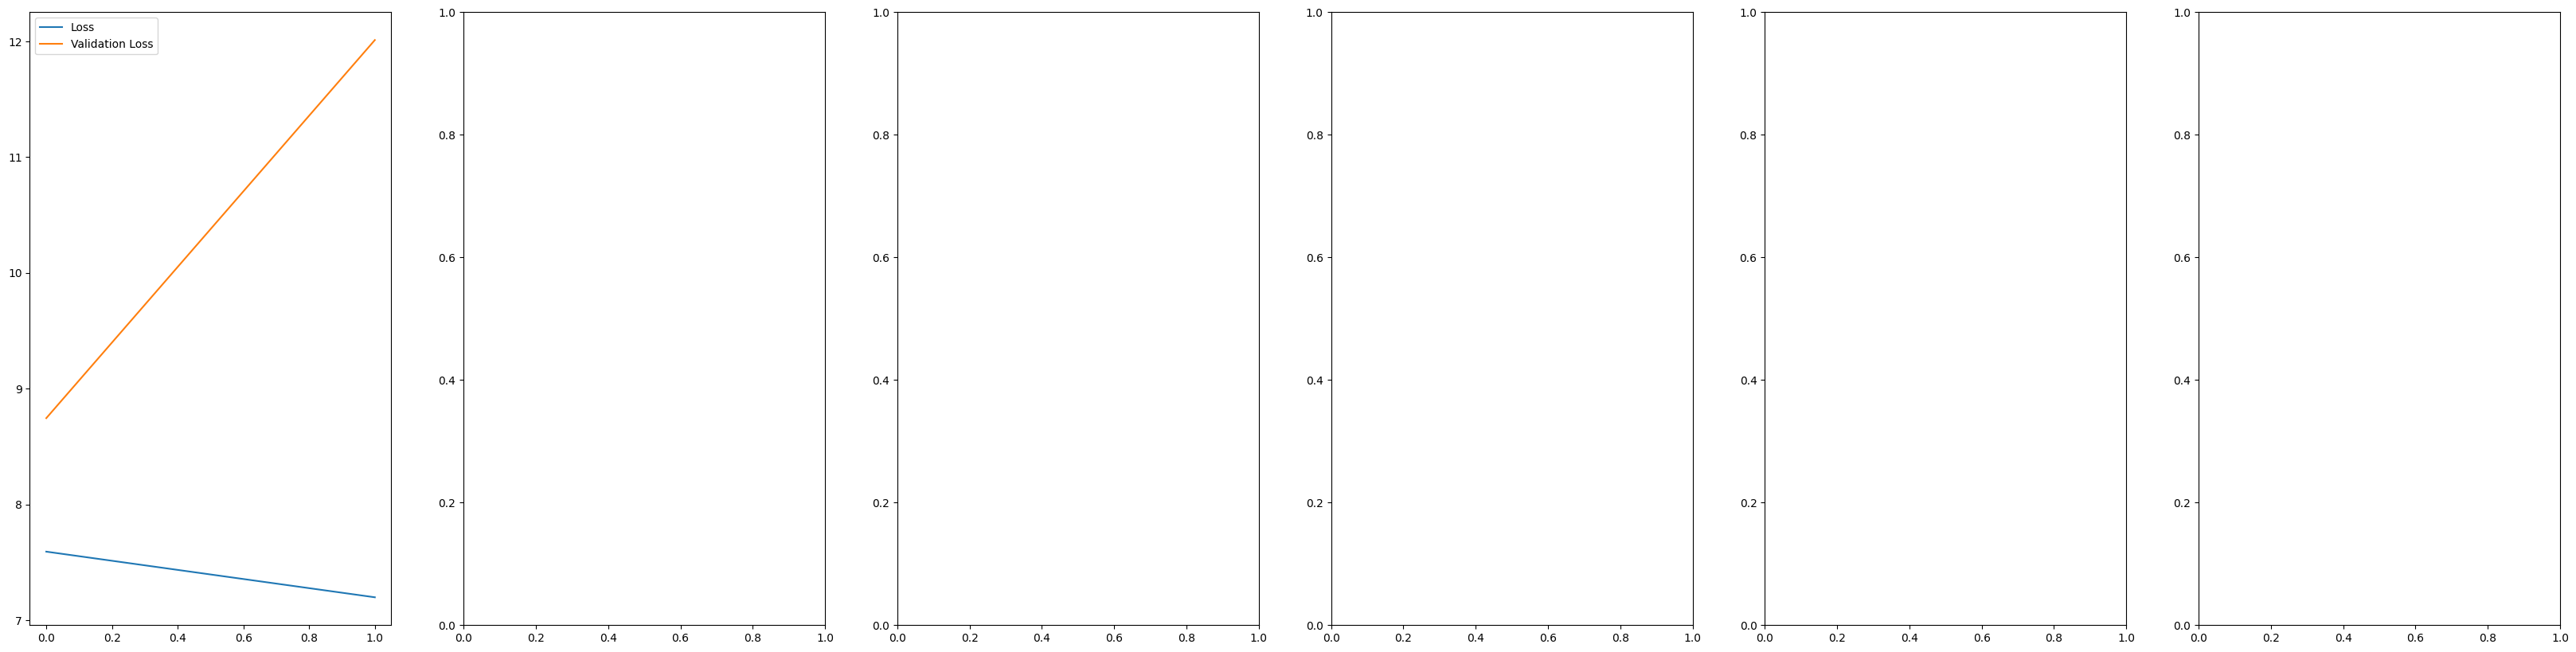

In [27]:
#plot graphs
# folder=['holes":1.0,"potato": 1.0,"rotten": 1.0,"cuts"]
fig, (ax0,ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 6, figsize = (41, 10))
# fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize = (17, 5))

ax0.plot(H.history['loss'], '-', label = 'Loss')
ax0.plot(H.history['val_loss'], '-', label = 'Validation Loss')
ax0.legend()
plt.savefig('loss.png')

ax1.plot(100*np.array(H.history['Sprout_iou_score']), '-', 
         label = 'Accuracy_Sprout')
ax1.plot(100*np.array(H.history['val_Sprout_iou_score']), '-',
         label = 'Validation Accuracy_Sprout')
ax1.legend()


ax4.plot(100*np.array(H.history['Peeled_iou_score']), '-', 
         label = 'Accuracy_Peeled')
ax4.plot(100*np.array(H.history['val_Peeled_iou_score']), '-',
         label = 'Validation Accuracy_Peeled')
ax4.legend()



ax2.plot(100*np.array(H.history['Rotten_iou_score']), '-', 
         label = 'Accuracy_Rotten')
ax2.plot(100*np.array(H.history['val_Rotten_iou_score']), '-',
         label = 'Validation Accuracy_Rotten')
ax2.legend()


ax3.plot(100*np.array(H.history['Background_iou_score']), '-', 
         label = 'Accuracy_Background')
ax3.plot(100*np.array(H.history['val_Background_iou_score']), '-',
         label = 'Validation Accuracy_Background')
ax3.legend()





# ax4.plot(100*np.array(H.history['Peeled_iou_score']), '-', 
#          label = 'Accuracy_Peeled')
# ax4.plot(100*np.array(H.history['val_Peeled_iou_score']), '-',
#          label = 'Validation Accuracy_Peeled')
# ax4.legend()

In [ ]:
import pandas as pd
matrix_dict = {"train_loss":[],"val_loss":[],train.....}

In [ ]:
import tensorflow as tf
from tqdm import tqdm

train_losses = []
train_ious_sprout = []
train_ious_peeled = []
train_ious_rotten = []
train_ious_double = []
train_ious_background = []

train_f1_scores_sprout = []
train_f1_scores_peeled = []
train_f1_scores_rotten = []
train_f1_scores_double = []
train_f1_scores_background = []


val_losses = []
val_ious_sprout = []
val_ious_peeled = []
val_ious_rotten = []
val_ious_double = []
val_ious_background = []

val_f1_scores_sprout = []
val_f1_scores_peeled = []
val_f1_scores_rotten = []
val_f1_scores_double = []
val_f1_scores_background = []

train_precisions_sprout = []
train_precisions_peeled = []
train_precisions_rotten = []
train_precisions_double = []
train_precisions_background = []

train_recalls_sprout = []
train_recalls_peeled = []
train_recalls_rotten = []
train_recalls_double = []
train_recalls_background = []

val_precisions_sprout = []
val_precisions_peeled = []
val_precisions_rotten = []
val_precisions_double = []
val_precisions_background = []

val_recalls_sprout = []
val_recalls_peeled = []
val_recalls_rotten = []
val_recalls_double = []
val_recalls_background = []






# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    
    # Initialize the training metrics
    train_loss = 0.0
    train_iou_sprout = 0.0
    train_iou_peeled = 0.0
    train_iou_rotten = 0.0
    train_iou_double = 0.0
    train_iou_background = 0.0
    train_f1_score_sprout = 0.0
    train_f1_score_peeled = 0.0
    train_f1_score_rotten = 0.0
    train_f1_score_double = 0.0
    train_f1_score_background = 0.0
    train_precision_sprout = 0.0
    train_precision_peeled = 0.0
    train_precision_rotten = 0.0
    train_precision_double = 0.0
    train_precision_background = 0.0
    train_recall_sprout = 0.0
    train_recall_peeled = 0.0
    train_recall_rotten = 0.0
    train_recall_double = 0.0
    train_recall_background = 0.0
    num_batches = 0
    
    # Iterate over the training dataset
    for step, (images, sprout_masks, peeled_masks, rotten_masks, double_masks, background_masks) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            sprout_pred, peeled_pred, rotten_pred, double_pred, background_pred = model_new(images, training=True)
            sprout_loss = sm.losses.bce_jaccard_loss(sprout_masks, sprout_pred)
            peeled_loss = sm.losses.bce_jaccard_loss(peeled_masks, peeled_pred)
            rotten_loss = sm.losses.bce_jaccard_loss(rotten_masks, rotten_pred)
            double_loss = sm.losses.bce_jaccard_loss(double_masks, double_pred)
            background_loss = sm.losses.bce_jaccard_loss(background_masks, background_pred)


            iou_sprout = iou_score(sprout_masks, sprout_pred)
            iou_peeled = iou_score(peeled_masks, peeled_pred)
            iou_rotten = iou_score(rotten_masks, rotten_pred)
            iou_double = iou_score(double_masks, double_pred)
            iou_background = iou_score(background_masks, background_pred)
            
            f1_sprout = f1_score(sprout_masks, sprout_pred)
            f1_peeled = f1_score(peeled_masks, peeled_pred)
            f1_rotten = f1_score(rotten_masks, rotten_pred)
            f1_double = f1_score(double_masks, double_pred)
            f1_background = f1_score(background_masks, background_pred)
            
            precision_sprout = precision(sprout_masks, sprout_pred)
            precision_peeled = precision(peeled_masks, peeled_pred)
            precision_rotten = precision(rotten_masks, rotten_pred)
            precision_double = precision(double_masks, double_pred)
            precision_background = precision(background_masks, background_pred)
            
            recall_sprout = recall(sprout_masks, sprout_pred)
            recall_peeled = recall(peeled_masks, peeled_pred)
            recall_rotten = recall(rotten_masks, rotten_pred)
            recall_double = recall(double_masks, double_pred)
            recall_background = recall(background_masks, background_pred)
            




            

            total_loss = sprout_loss + peeled_loss + rotten_loss + double_loss + background_loss

        gradients = tape.gradient(total_loss, model_new.trainable_variables)
        opt.apply_gradients(zip(gradients, model_new.trainable_variables))

        
        train_loss += total_loss
        train_iou_sprout += iou_sprout
        train_iou_peeled += iou_peeled
        train_iou_rotten += iou_rotten
        train_iou_double += iou_double
        train_iou_background += iou_background

        train_f1_score_sprout += f1_sprout
        train_f1_score_peeled += f1_peeled
        train_f1_score_rotten += f1_rotten
        train_f1_score_double += f1_double
        train_f1_score_background += f1_background

        train_precision_sprout += precision_sprout
        train_precision_peeled += precision_peeled
        train_precision_rotten += precision_rotten
        train_precision_double += precision_double
        train_precision_background += precision_background

        train_recall_sprout += recall_sprout
        train_recall_peeled += recall_peeled
        train_recall_rotten += recall_rotten
        train_recall_double += recall_double
        train_recall_background += recall_background

        if (step + 1) % 40 == 0:
            
            print("Epoch {}/{}, Iteration {}/{} - train_Loss: {:.4f}, train_IOU Sprout: {:.4f}, train_IOU Peeled: {:.4f}, train_IOU Rotten: {:.4f}, train_IOU Double: {:.4f}, train_IOU Background: {:.4f}, train_F1 Score Sprout: {:.4f}, train_F1 Score Peeled: {:.4f}, train_F1 Score Rotten: {:.4f}, train_F1 Score Double: {:.4f}, train_F1 Score Background: {:.4f}, train_Precision Sprout: {:.4f}, train_Precision Peeled: {:.4f}, train_Precision Rotten: {:.4f}, train_Precision Double: {:.4f}, train_Precision Background: {:.4f}, train_Recall Sprout: {:.4f}, train_Recall Peeled: {:.4f}, train_Recall Rotten: {:.4f}, train_Recall double: {:.4f}, train_Recall Background: {:.4f}".format(epoch + 1, num_epochs, step + 1, len(train_dataset), total_loss.numpy(), iou_sprout,iou_peeled,iou_rotten,iou_double,iou_background,f1_sprout,f1_peeled,f1_rotten,f1_double,f1_background,precision_sprout,precision_peeled,precision_rotten, precision_double,precision_background,recall_sprout,recall_peeled,recall_rotten,recall_double,recall_background))
       
        
    


        
        num_batches += 1
    
    # Calculate average metrics for the epoch
    train_loss /= num_batches
    train_iou_sprout /= num_batches
    train_iou_peeled /= num_batches
    train_iou_rotten /= num_batches
    train_iou_double /= num_batches
    train_iou_background /= num_batches
    
    train_f1_score_sprout /= num_batches
    train_f1_score_peeled /= num_batches
    train_f1_score_rotten /= num_batches
    train_f1_score_double /= num_batches
    train_f1_score_background /= num_batches

    train_precision_sprout /= num_batches
    train_precision_peeled /= num_batches
    train_precision_rotten /= num_batches
    train_precision_double /= num_batches
    train_precision_background /= num_batches

    train_recall_sprout /= num_batches
    train_recall_peeled /= num_batches
    train_recall_rotten /= num_batches
    train_recall_double /= num_batches
    train_recall_background /= num_batches

     # Append the values to the respective lists
    train_losses.append(train_loss)
    train_ious_sprout.append(train_iou_sprout)
    train_ious_peeled.append(train_iou_peeled)
    train_ious_rotten.append(train_iou_rotten)
    train_ious_double.append(train_iou_double)
    train_ious_background.append(train_iou_background)
    
    train_f1_scores_sprout.append(train_f1_score_sprout)
    train_f1_scores_peeled.append(train_f1_score_peeled)
    train_f1_scores_rotten.append(train_f1_score_rotten)
    train_f1_scores_double.append(train_f1_score_double)
    train_f1_scores_background.append(train_f1_score_background)
    
    train_precisions_sprout.append(train_precision_sprout)
    train_precisions_peeled.append(train_precision_peeled)
    train_precisions_rotten.append(train_precision_rotten)
    train_precisions_double.append(train_precision_double)
    train_precisions_background.append(train_precision_background)
    
    train_recalls_sprout.append(train_recall_sprout)
    train_recalls_peeled.append(train_recall_peeled)
    train_recalls_rotten.append(train_recall_rotten)
    train_recalls_double.append(train_recall_double)
    train_recalls_background.append(train_recall_background)

    


    print("Training Loss: {:.4f}, Train_IOU Sprout: {:.4f}, Train_IOU Peeled: {:.4f}, Train_IOU Rotten: {:.4f}, Train_IOU Double: {:.4f}, Train_IOU Background: {:.4f},Train_F1 Score Sprout: {:.4f}, Train_F1 Score Peeled: {:.4f}, Train_F1 Score Rotten: {:.4f}, Train_F1 Score Double: {:.4f}, Train_F1 Score Background: {:.4f},Train_Precision Sprout: {:.4f},Train_Precision Peeled: {:.4f}, Train_Precision Rotten: {:.4f},Train_Precision Double: {:.4f},Train_Precision Background: {:.4f},Train_Recall Sprout: {:.4f},Train_Recall Peeled: {:.4f},Train_Recall Rotten: {:.4f},Train_Recall Double: {:.4f},Train_Recall Background: {:.4f}".format(train_loss, train_iou_sprout, train_iou_peeled, train_iou_rotten, train_iou_double, train_iou_background,train_f1_score_sprout, train_f1_score_peeled, train_f1_score_rotten, train_f1_score_double, train_f1_score_background,train_precision_sprout, train_precision_peeled, train_precision_rotten, train_precision_double, train_precision_background,train_recall_sprout, train_recall_peeled, train_recall_rotten, train_recall_double, train_recall_background))


    val_loss = 0.0
    val_iou_sprout = 0.0
    val_iou_peeled = 0.0
    val_iou_rotten = 0.0
    val_iou_double = 0.0
    val_iou_background = 0.0
    val_f1_score_sprout = 0.0
    val_f1_score_peeled = 0.0
    val_f1_score_rotten = 0.0
    val_f1_score_double = 0.0
    val_f1_score_background = 0.0
    val_precision_sprout = 0.0
    val_precision_peeled = 0.0
    val_precision_rotten = 0.0
    val_precision_double = 0.0
    val_precision_background = 0.0
    val_recall_sprout = 0.0
    val_recall_peeled = 0.0
    val_recall_rotten = 0.0
    val_recall_double = 0.0
    val_recall_background = 0.0
    num_val_batches = 0
    
    for val_images, val_sprout_masks, val_peeled_masks, val_rotten_masks, val_double_masks, val_background_masks in val_dataset:
        # Predict
        val_sprout_pred, val_peeled_pred, val_rotten_pred, val_double_pred, val_background_pred = model_new(val_images, training=False)

        # Compute the loss for each output
        val_sprout_loss = sm.losses.bce_jaccard_loss(val_sprout_masks, val_sprout_pred)
        val_peeled_loss = sm.losses.bce_jaccard_loss(val_peeled_masks, val_peeled_pred)
        val_rotten_loss = sm.losses.bce_jaccard_loss(val_rotten_masks, val_rotten_pred)
        val_double_loss = sm.losses.bce_jaccard_loss(val_double_masks, val_double_pred)
        val_background_loss = sm.losses.bce_jaccard_loss(val_background_masks, val_background_pred)

        # Compute total loss
        val_total_loss = (val_sprout_loss + val_peeled_loss + val_rotten_loss + val_double_loss + val_background_loss).numpy()

        # Update validation metrics
        val_loss += val_total_loss
        val_iou_sprout += iou_score(val_sprout_masks, val_sprout_pred)
        val_iou_peeled += iou_score(val_peeled_masks, val_peeled_pred)
        val_iou_rotten += iou_score(val_rotten_masks, val_rotten_pred)
        val_iou_double += iou_score(val_double_masks, val_double_pred)
        val_iou_background += iou_score(val_background_masks, val_background_pred)
        
        val_f1_score_sprout += f1_score(val_sprout_masks, val_sprout_pred)
        val_f1_score_peeled += f1_score(val_peeled_masks, val_peeled_pred)
        val_f1_score_rotten += f1_score(val_rotten_masks, val_rotten_pred)
        val_f1_score_double += f1_score(val_double_masks, val_double_pred)
        val_f1_score_background += f1_score(val_background_masks, val_background_pred)
        
        val_precision_sprout += precision(val_sprout_masks, val_sprout_pred)
        val_precision_peeled += precision(val_peeled_masks, val_peeled_pred)
        val_precision_rotten += precision(val_rotten_masks, val_rotten_pred)
        val_precision_double += precision(val_double_masks, val_double_pred)
        val_precision_background += precision(val_background_masks, val_background_pred)
        
        val_recall_sprout += recall(val_sprout_masks, val_sprout_pred)
        val_recall_peeled += recall(val_peeled_masks, val_peeled_pred)
        val_recall_rotten += recall(val_rotten_masks, val_rotten_pred)
        val_recall_double += recall(val_double_masks, val_double_pred)
        val_recall_background += recall(val_background_masks, val_background_pred)

        num_val_batches += 1

        if (step + 1) % 40 == 0:
            print("Epoch {}/{}, Iteration {}/{} - val_Loss: {:.4f}, val_IOU Sprout: {:.4f}, val_IOU Peeled: {:.4f}, val_IOU Rotten: {:.4f}, val_IOU Double: {:.4f}, val_IOU Background: {:.4f}, val_F1 Score Sprout: {:.4f}, val_F1 Score Peeled: {:.4f}, val_F1 Score Rotten: {:.4f}, val_F1 Score Double: {:.4f}, val_F1 Score Background: {:.4f}, val_Precision Sprout: {:.4f}, val_Precision Peeled: {:.4f}, val_Precision Rotten: {:.4f}, val_Precision Double: {:.4f}, val_Precision Background: {:.4f}, val_Recall Sprout: {:.4f}, val_Recall Peeled: {:.4f}, val_Recall Rotten: {:.4f}, val_Recall Double: {:.4f}, val_Recall Background: {:.4f}".format(epoch + 1, num_epochs, step + 1, len(train_dataset), val_loss, val_iou_sprout, val_iou_peeled, val_iou_rotten, val_iou_double, val_iou_background, val_f1_score_sprout, val_f1_score_peeled, val_f1_score_rotten, val_f1_score_double, val_f1_score_background, val_precision_sprout, val_precision_peeled, val_precision_rotten, val_precision_double, val_precision_background, val_recall_sprout, val_recall_peeled, val_recall_rotten, val_recall_double, val_recall_background))

            
 
                                    
            



    
    # Calculate average validation metrics
    val_loss /= num_val_batches
    val_iou_sprout /= num_val_batches
    val_iou_peeled /= num_val_batches
    val_iou_rotten /= num_val_batches
    val_iou_double /= num_val_batches
    val_iou_background /= num_val_batches
    
    val_f1_score_sprout /= num_val_batches
    val_f1_score_peeled /= num_val_batches
    val_f1_score_rotten /= num_val_batches
    val_f1_score_double /= num_val_batches
    val_f1_score_background /= num_val_batches
    
    val_precision_sprout /= num_val_batches
    val_precision_peeled /= num_val_batches
    val_precision_rotten /= num_val_batches
    val_precision_double /= num_val_batches
    val_precision_background /= num_val_batches
    
    val_recall_sprout /= num_val_batches
    val_recall_peeled /= num_val_batches
    val_recall_rotten /= num_val_batches
    val_recall_double /= num_val_batches
    val_recall_background /= num_val_batches


    val_losses.append(val_loss)
    val_ious_sprout.append(val_iou_sprout)
    val_ious_peeled.append(val_iou_peeled)
    val_ious_rotten.append(val_iou_rotten)
    val_ious_double.append(val_iou_double)
    val_ious_background.append(val_iou_background)
    
    val_f1_scores_sprout.append(val_f1_score_sprout)
    val_f1_scores_peeled.append(val_f1_score_peeled)
    val_f1_scores_rotten.append(val_f1_score_rotten)
    val_f1_scores_double.append(val_f1_score_double)
    val_f1_scores_background.append(val_f1_score_background)
    
    val_precisions_sprout.append(val_precision_sprout)
    val_precisions_peeled.append(val_precision_peeled)
    val_precisions_rotten.append(val_precision_rotten)
    val_precisions_double.append(val_precision_double)
    val_precisions_background.append(val_precision_background)
    
    val_recalls_sprout.append(val_recall_sprout)
    val_recalls_peeled.append(val_recall_peeled)
    val_recalls_rotten.append(val_recall_rotten)
    val_recalls_double.append(val_recall_double)
    val_recalls_background.append(val_recall_background)



    reduce_rl_plateau.on_epoch_end(epoch, val_loss)

    current_lr = opt.learning_rate.numpy()
    print("Learning Rate:", current_lr)


    print("Validation Loss: {:.4f}, Val_IOU Sprout: {:.4f}, Val_IOU Peeled: {:.4f}, Val_IOU Rotten: {:.4f}, Val_IOU Double: {:.4f}, Val_IOU Background: {:.4f}, Val_F1 Score Sprout: {:.4f}, Val_F1 Score Peeled: {:.4f}, Val_F1 Score Rotten: {:.4f}, Val_F1 Score Double: {:.4f}, Val_F1 Score Background: {:.4f}, Val_Precision Sprout: {:.4f}, Val_Precision Peeled: {:.4f}, Val_Precision Rotten: {:.4f}, Val_Precision Double: {:.4f}, Val_Precision Background: {:.4f}, Val_Recall Sprout: {:.4f}, Val_Recall Peeled: {:.4f}, Val_Recall Rotten: {:.4f}, Val_Recall Double: {:.4f}, Val_Recall Background: {:.4f}".format(val_loss, val_iou_sprout, val_iou_peeled, val_iou_rotten, val_iou_double, val_iou_background,val_f1_score_sprout, val_f1_score_peeled, val_f1_score_rotten, val_f1_score_double, val_f1_score_background,val_precision_sprout, val_precision_peeled, val_precision_rotten, val_precision_double, val_precision_background,val_recall_sprout, val_recall_peeled, val_recall_rotten, val_recall_double, val_recall_background))
    model_new.save("model_epoch_{}.h5".format(epoch+1))


Epochs:   0%|                                            | 0/20 [00:00<?, ?it/s]

Epoch 1/20


2024-03-16 15:42:04.821622: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-03-16 15:42:05.790394: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-16 15:42:05.790864: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-16 15:42:05.790875: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-03-16 15:42:05.791396: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-16 15:42:05.791434: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1/20, Iteration 40/1248 - train_Loss: 6.2550, train_IOU Sprout: 0.2748, train_IOU Peeled: 0.3162, train_IOU Rotten: 0.2683, train_IOU Double: 0.2832, train_IOU Background: 0.6294, train_F1 Score Sprout: 0.3547, train_F1 Score Peeled: 0.4211, train_F1 Score Rotten: 0.3498, train_F1 Score Double: 0.3628, train_F1 Score Background: 0.7679, train_Precision Sprout: 0.5000, train_Precision Peeled: 0.5292, train_Precision Rotten: 0.4984, train_Precision Double: 0.5003, train_Precision Background: 0.7361, train_Recall Sprout: 0.4460, train_Recall Peeled: 0.7482, train_Recall Rotten: 0.3609, train_Recall double: 0.5476, train_Recall Background: 0.9025
Epoch 1/20, Iteration 80/1248 - train_Loss: 5.5952, train_IOU Sprout: 0.3047, train_IOU Peeled: 0.3819, train_IOU Rotten: 0.2966, train_IOU Double: 0.3053, train_IOU Background: 0.7801, train_F1 Score Sprout: 0.3786, train_F1 Score Peeled: 0.5028, train_F1 Score Rotten: 0.3734, train_F1 Score Double: 0.3793, train_F1 Score Background: 0.8768

Epochs:   5%|█▍                           | 1/20 [2:27:10<46:36:12, 8830.13s/it]

Epoch 2/20
Epoch 2/20, Iteration 40/1248 - train_Loss: 2.1784, train_IOU Sprout: 0.5928, train_IOU Peeled: 0.6198, train_IOU Rotten: 0.5124, train_IOU Double: 0.5269, train_IOU Background: 0.8339, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.8755, train_F1 Score Rotten: 0.4993, train_F1 Score Double: 0.4999, train_F1 Score Background: 0.9099, train_Precision Sprout: 0.5000, train_Precision Peeled: 0.8718, train_Precision Rotten: 0.4990, train_Precision Double: 0.4998, train_Precision Background: 0.8709, train_Recall Sprout: 1.0000, train_Recall Peeled: 0.8792, train_Recall Rotten: 0.4996, train_Recall double: 0.4999, train_Recall Background: 0.9684
Epoch 2/20, Iteration 80/1248 - train_Loss: 2.1683, train_IOU Sprout: 0.5867, train_IOU Peeled: 0.6114, train_IOU Rotten: 0.5140, train_IOU Double: 0.5331, train_IOU Background: 0.9084, train_F1 Score Sprout: 0.4999, train_F1 Score Peeled: 0.7688, train_F1 Score Rotten: 0.4997, train_F1 Score Double: 0.4999, train_F1 Score Backgro

Epochs:  10%|██▉                          | 2/20 [4:54:13<44:07:46, 8825.89s/it]

Learning Rate: 0.001
Validation Loss: 2.7099, Val_IOU Sprout: 0.7307, Val_IOU Peeled: 0.6103, Val_IOU Rotten: 0.6797, Val_IOU Double: 0.7858, Val_IOU Background: 0.4805, Val_F1 Score Sprout: 0.5138, Val_F1 Score Peeled: 0.4996, Val_F1 Score Rotten: 0.5000, Val_F1 Score Double: 0.5000, Val_F1 Score Background: 0.4928, Val_Precision Sprout: 0.5151, Val_Precision Peeled: 0.5002, Val_Precision Rotten: 0.4999, Val_Precision Double: 0.5000, Val_Precision Background: 0.5040, Val_Recall Sprout: 0.9819, Val_Recall Peeled: 0.9166, Val_Recall Rotten: 0.9775, Val_Recall Double: 0.9872, Val_Recall Background: 0.8742
Epoch 3/20
Epoch 3/20, Iteration 40/1248 - train_Loss: 2.1117, train_IOU Sprout: 0.9043, train_IOU Peeled: 0.5605, train_IOU Rotten: 0.6145, train_IOU Double: 0.6093, train_IOU Background: 0.9364, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.7527, train_F1 Score Rotten: 0.4998, train_F1 Score Double: 0.4996, train_F1 Score Background: 0.9713, train_Precision Sprout: 0.5000, t

Epochs:  15%|████▎                        | 3/20 [7:22:05<41:46:45, 8847.37s/it]

Learning Rate: 0.001
Validation Loss: 2.5861, Val_IOU Sprout: 0.8165, Val_IOU Peeled: 0.6718, Val_IOU Rotten: 0.7641, Val_IOU Double: 0.9306, Val_IOU Background: 0.4944, Val_F1 Score Sprout: 0.5091, Val_F1 Score Peeled: 0.5411, Val_F1 Score Rotten: 0.4999, Val_F1 Score Double: 0.5000, Val_F1 Score Background: 0.5594, Val_Precision Sprout: 0.5086, Val_Precision Peeled: 0.5631, Val_Precision Rotten: 0.4999, Val_Precision Double: 0.5000, Val_Precision Background: 0.5785, Val_Recall Sprout: 0.9898, Val_Recall Peeled: 0.9507, Val_Recall Rotten: 0.9519, Val_Recall Double: 0.9808, Val_Recall Background: 0.9307
Epoch 4/20
Epoch 4/20, Iteration 40/1248 - train_Loss: 1.7276, train_IOU Sprout: 0.7347, train_IOU Peeled: 0.6992, train_IOU Rotten: 0.6221, train_IOU Double: 0.8360, train_IOU Background: 0.9445, train_F1 Score Sprout: 0.8039, train_F1 Score Peeled: 0.8740, train_F1 Score Rotten: 0.4989, train_F1 Score Double: 0.4997, train_F1 Score Background: 0.9725, train_Precision Sprout: 0.7867, t

Epochs:  20%|█████▊                       | 4/20 [9:49:02<39:16:04, 8835.27s/it]

Learning Rate: 0.001
Validation Loss: 2.4449, Val_IOU Sprout: 0.8634, Val_IOU Peeled: 0.7001, Val_IOU Rotten: 0.7513, Val_IOU Double: 0.8655, Val_IOU Background: 0.5118, Val_F1 Score Sprout: 0.5134, Val_F1 Score Peeled: 0.5438, Val_F1 Score Rotten: 0.5095, Val_F1 Score Double: 0.5022, Val_F1 Score Background: 0.6089, Val_Precision Sprout: 0.5128, Val_Precision Peeled: 0.5486, Val_Precision Rotten: 0.5089, Val_Precision Double: 0.5019, Val_Precision Background: 0.6094, Val_Recall Sprout: 0.9885, Val_Recall Peeled: 0.9725, Val_Recall Rotten: 0.9716, Val_Recall Double: 0.9863, Val_Recall Background: 0.9807
Epoch 5/20
Epoch 5/20, Iteration 40/1248 - train_Loss: 1.7993, train_IOU Sprout: 0.9223, train_IOU Peeled: 0.6486, train_IOU Rotten: 0.6764, train_IOU Double: 0.8266, train_IOU Background: 0.9013, train_F1 Score Sprout: 0.4999, train_F1 Score Peeled: 0.9229, train_F1 Score Rotten: 0.7022, train_F1 Score Double: 0.4998, train_F1 Score Background: 0.9493, train_Precision Sprout: 0.5000, t

Epochs:  25%|███████                     | 5/20 [12:15:56<36:46:51, 8827.41s/it]

Epoch 6/20
Epoch 6/20, Iteration 40/1248 - train_Loss: 1.9805, train_IOU Sprout: 0.9542, train_IOU Peeled: 0.7216, train_IOU Rotten: 0.7455, train_IOU Double: 0.8679, train_IOU Background: 0.9076, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.8906, train_F1 Score Rotten: 0.4992, train_F1 Score Double: 0.4999, train_F1 Score Background: 0.9525, train_Precision Sprout: 0.5000, train_Precision Peeled: 0.9001, train_Precision Rotten: 0.4992, train_Precision Double: 0.4997, train_Precision Background: 0.9253, train_Recall Sprout: 1.0000, train_Recall Peeled: 0.8815, train_Recall Rotten: 0.5000, train_Recall double: 0.5000, train_Recall Background: 0.9860
Epoch 6/20, Iteration 80/1248 - train_Loss: 1.7754, train_IOU Sprout: 0.7782, train_IOU Peeled: 0.6092, train_IOU Rotten: 0.8191, train_IOU Double: 0.7443, train_IOU Background: 0.9685, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.9296, train_F1 Score Rotten: 0.4999, train_F1 Score Double: 0.4995, train_F1 Score Backgro

Epochs:  30%|████████▍                   | 6/20 [14:43:03<34:19:44, 8827.48s/it]

Learning Rate: 0.001
Validation Loss: 6.1246, Val_IOU Sprout: 0.8359, Val_IOU Peeled: 0.5347, Val_IOU Rotten: 0.9087, Val_IOU Double: 0.8626, Val_IOU Background: 0.3957, Val_F1 Score Sprout: 0.5162, Val_F1 Score Peeled: 0.5167, Val_F1 Score Rotten: 0.5000, Val_F1 Score Double: 0.5000, Val_F1 Score Background: 0.4860, Val_Precision Sprout: 0.5177, Val_Precision Peeled: 0.5188, Val_Precision Rotten: 0.5001, Val_Precision Double: 0.5001, Val_Precision Background: 0.5445, Val_Recall Sprout: 0.9856, Val_Recall Peeled: 0.9668, Val_Recall Rotten: 0.9647, Val_Recall Double: 0.9872, Val_Recall Background: 0.8625
Epoch 7/20
Epoch 7/20, Iteration 40/1248 - train_Loss: 1.8841, train_IOU Sprout: 0.8795, train_IOU Peeled: 0.6724, train_IOU Rotten: 0.7663, train_IOU Double: 0.7047, train_IOU Background: 0.9544, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.8474, train_F1 Score Rotten: 0.5121, train_F1 Score Double: 0.6291, train_F1 Score Background: 0.9766, train_Precision Sprout: 0.5000, t

Epochs:  35%|█████████▊                  | 7/20 [17:10:09<31:52:30, 8826.97s/it]

Learning Rate: 0.001
Validation Loss: 2.8663, Val_IOU Sprout: 0.8139, Val_IOU Peeled: 0.6651, Val_IOU Rotten: 0.8951, Val_IOU Double: 0.9329, Val_IOU Background: 0.4583, Val_F1 Score Sprout: 0.5126, Val_F1 Score Peeled: 0.5482, Val_F1 Score Rotten: 0.5080, Val_F1 Score Double: 0.5002, Val_F1 Score Background: 0.5419, Val_Precision Sprout: 0.5125, Val_Precision Peeled: 0.5483, Val_Precision Rotten: 0.5095, Val_Precision Double: 0.5030, Val_Precision Background: 0.5600, Val_Recall Sprout: 0.9914, Val_Recall Peeled: 0.9855, Val_Recall Rotten: 0.9864, Val_Recall Double: 0.9873, Val_Recall Background: 0.9374
Epoch 8/20
Epoch 8/20, Iteration 40/1248 - train_Loss: 1.6253, train_IOU Sprout: 0.9426, train_IOU Peeled: 0.6425, train_IOU Rotten: 0.8280, train_IOU Double: 0.7385, train_IOU Background: 0.9441, train_F1 Score Sprout: 0.8665, train_F1 Score Peeled: 0.8421, train_F1 Score Rotten: 0.5001, train_F1 Score Double: 0.6132, train_F1 Score Background: 0.9713, train_Precision Sprout: 0.9475, t

Epochs:  40%|███████████▏                | 8/20 [19:37:06<29:24:43, 8823.63s/it]


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Learning Rate: 0.000100000005
Validation Loss: 2.5272, Val_IOU Sprout: 0.9237, Val_IOU Peeled: 0.6430, Val_IOU Rotten: 0.9850, Val_IOU Double: 0.9739, Val_IOU Background: 0.5034, Val_F1 Score Sprout: 0.5161, Val_F1 Score Peeled: 0.5623, Val_F1 Score Rotten: 0.5000, Val_F1 Score Double: 0.5000, Val_F1 Score Background: 0.6155, Val_Precision Sprout: 0.5201, Val_Precision Peeled: 0.5551, Val_Precision Rotten: 0.5018, Val_Precision Double: 0.5001, Val_Precision Background: 0.6144, Val_Recall Sprout: 0.9824, Val_Recall Peeled: 0.9844, Val_Recall Rotten: 0.9615, Val_Recall Double: 0.9934, Val_Recall Background: 0.9741
Epoch 9/20
Epoch 9/20, Iteration 40/1248 - train_Loss: 3.7027, train_IOU Sprout: 0.9413, train_IOU Peeled: 0.6080, train_IOU Rotten: 0.8856, train_IOU Double: 0.7482, train_IOU Background: 0.2422, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.6870, train_F1 Score Rotten: 0.5000, train_F1

Epochs:  45%|████████████▌               | 9/20 [22:04:05<26:57:24, 8822.23s/it]

Learning Rate: 0.000100000005
Validation Loss: 2.3253, Val_IOU Sprout: 0.9312, Val_IOU Peeled: 0.7340, Val_IOU Rotten: 0.9341, Val_IOU Double: 0.9829, Val_IOU Background: 0.5279, Val_F1 Score Sprout: 0.5398, Val_F1 Score Peeled: 0.5611, Val_F1 Score Rotten: 0.5138, Val_F1 Score Double: 0.5018, Val_F1 Score Background: 0.6264, Val_Precision Sprout: 0.5398, Val_Precision Peeled: 0.5598, Val_Precision Rotten: 0.5189, Val_Precision Double: 0.5068, Val_Precision Background: 0.6260, Val_Recall Sprout: 0.9942, Val_Recall Peeled: 0.9852, Val_Recall Rotten: 0.9709, Val_Recall Double: 0.9852, Val_Recall Background: 0.9987
Epoch 10/20
Epoch 10/20, Iteration 40/1248 - train_Loss: 2.0450, train_IOU Sprout: 0.7634, train_IOU Peeled: 0.7114, train_IOU Rotten: 0.6893, train_IOU Double: 0.8112, train_IOU Background: 0.8031, train_F1 Score Sprout: 0.6309, train_F1 Score Peeled: 0.9216, train_F1 Score Rotten: 0.4995, train_F1 Score Double: 0.4999, train_F1 Score Background: 0.8701, train_Precision Sprout

Epochs:  50%|█████████████▌             | 10/20 [24:31:05<24:30:16, 8821.70s/it]

Learning Rate: 0.000100000005
Validation Loss: 2.3580, Val_IOU Sprout: 0.9282, Val_IOU Peeled: 0.7709, Val_IOU Rotten: 0.9272, Val_IOU Double: 0.9759, Val_IOU Background: 0.5227, Val_F1 Score Sprout: 0.5168, Val_F1 Score Peeled: 0.5685, Val_F1 Score Rotten: 0.5101, Val_F1 Score Double: 0.5002, Val_F1 Score Background: 0.6272, Val_Precision Sprout: 0.5161, Val_Precision Peeled: 0.5677, Val_Precision Rotten: 0.5130, Val_Precision Double: 0.5008, Val_Precision Background: 0.6259, Val_Recall Sprout: 0.9947, Val_Recall Peeled: 0.9866, Val_Recall Rotten: 0.9771, Val_Recall Double: 0.9873, Val_Recall Background: 0.9978
Epoch 11/20
Epoch 11/20, Iteration 40/1248 - train_Loss: 1.3495, train_IOU Sprout: 0.9332, train_IOU Peeled: 0.7521, train_IOU Rotten: 0.8345, train_IOU Double: 0.7805, train_IOU Background: 0.8963, train_F1 Score Sprout: 0.9656, train_F1 Score Peeled: 0.9258, train_F1 Score Rotten: 0.4999, train_F1 Score Double: 0.6786, train_F1 Score Background: 0.9491, train_Precision Sprout

Epochs:  55%|██████████████▊            | 11/20 [26:58:04<22:03:08, 8820.92s/it]

Learning Rate: 0.000100000005
Validation Loss: 2.3523, Val_IOU Sprout: 0.9435, Val_IOU Peeled: 0.7709, Val_IOU Rotten: 0.9351, Val_IOU Double: 0.9745, Val_IOU Background: 0.5199, Val_F1 Score Sprout: 0.5252, Val_F1 Score Peeled: 0.5679, Val_F1 Score Rotten: 0.5114, Val_F1 Score Double: 0.5014, Val_F1 Score Background: 0.6279, Val_Precision Sprout: 0.5244, Val_Precision Peeled: 0.5708, Val_Precision Rotten: 0.5210, Val_Precision Double: 0.5017, Val_Precision Background: 0.6269, Val_Recall Sprout: 0.9958, Val_Recall Peeled: 0.9713, Val_Recall Rotten: 0.9771, Val_Recall Double: 0.9852, Val_Recall Background: 0.9948
Epoch 12/20
Epoch 12/20, Iteration 40/1248 - train_Loss: 2.0567, train_IOU Sprout: 0.8468, train_IOU Peeled: 0.6840, train_IOU Rotten: 0.8322, train_IOU Double: 0.8602, train_IOU Background: 0.9140, train_F1 Score Sprout: 0.4999, train_F1 Score Peeled: 0.8336, train_F1 Score Rotten: 0.4999, train_F1 Score Double: 0.6180, train_F1 Score Background: 0.9554, train_Precision Sprout

Epochs:  60%|████████████████▏          | 12/20 [29:25:08<19:36:14, 8821.85s/it]

Learning Rate: 0.000100000005
Validation Loss: 2.5562, Val_IOU Sprout: 0.9656, Val_IOU Peeled: 0.7755, Val_IOU Rotten: 0.9285, Val_IOU Double: 0.9705, Val_IOU Background: 0.5138, Val_F1 Score Sprout: 0.5322, Val_F1 Score Peeled: 0.5752, Val_F1 Score Rotten: 0.5152, Val_F1 Score Double: 0.5000, Val_F1 Score Background: 0.6269, Val_Precision Sprout: 0.5306, Val_Precision Peeled: 0.5766, Val_Precision Rotten: 0.5190, Val_Precision Double: 0.5000, Val_Precision Background: 0.6278, Val_Recall Sprout: 0.9970, Val_Recall Peeled: 0.9771, Val_Recall Rotten: 0.9723, Val_Recall Double: 1.0000, Val_Recall Background: 0.9875
Epoch 13/20
Epoch 13/20, Iteration 40/1248 - train_Loss: 2.2943, train_IOU Sprout: 0.8022, train_IOU Peeled: 0.8272, train_IOU Rotten: 0.7430, train_IOU Double: 0.8693, train_IOU Background: 0.6390, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.9205, train_F1 Score Rotten: 0.6448, train_F1 Score Double: 0.4997, train_F1 Score Background: 0.7470, train_Precision Sprout

Epochs:  65%|█████████████████▌         | 13/20 [31:52:06<17:09:03, 8820.55s/it]

Epoch 14/20
Epoch 14/20, Iteration 40/1248 - train_Loss: 2.3922, train_IOU Sprout: 0.5665, train_IOU Peeled: 0.5150, train_IOU Rotten: 0.6228, train_IOU Double: 0.5771, train_IOU Background: 0.8442, train_F1 Score Sprout: 0.4998, train_F1 Score Peeled: 0.4942, train_F1 Score Rotten: 0.5704, train_F1 Score Double: 0.5358, train_F1 Score Background: 0.9043, train_Precision Sprout: 0.5000, train_Precision Peeled: 0.5000, train_Precision Rotten: 0.5944, train_Precision Double: 0.5804, train_Precision Background: 0.8848, train_Recall Sprout: 0.9996, train_Recall Peeled: 0.9886, train_Recall Rotten: 0.5562, train_Recall double: 0.5232, train_Recall Background: 0.9274
Epoch 14/20, Iteration 80/1248 - train_Loss: 2.3535, train_IOU Sprout: 0.7370, train_IOU Peeled: 0.8213, train_IOU Rotten: 0.6386, train_IOU Double: 0.8726, train_IOU Background: 0.7070, train_F1 Score Sprout: 0.4999, train_F1 Score Peeled: 0.9257, train_F1 Score Rotten: 0.7093, train_F1 Score Double: 0.5004, train_F1 Score Back

Epochs:  70%|██████████████████▉        | 14/20 [34:19:10<14:42:10, 8821.67s/it]

Learning Rate: 1.0000001e-05
Validation Loss: 2.3533, Val_IOU Sprout: 0.9179, Val_IOU Peeled: 0.7355, Val_IOU Rotten: 0.8922, Val_IOU Double: 0.9545, Val_IOU Background: 0.5182, Val_F1 Score Sprout: 0.5136, Val_F1 Score Peeled: 0.5701, Val_F1 Score Rotten: 0.5259, Val_F1 Score Double: 0.5035, Val_F1 Score Background: 0.6391, Val_Precision Sprout: 0.5116, Val_Precision Peeled: 0.5697, Val_Precision Rotten: 0.5279, Val_Precision Double: 0.5030, Val_Precision Background: 0.6375, Val_Recall Sprout: 0.9928, Val_Recall Peeled: 0.9725, Val_Recall Rotten: 0.9719, Val_Recall Double: 0.9933, Val_Recall Background: 0.9938
Epoch 15/20
Epoch 15/20, Iteration 40/1248 - train_Loss: 1.4636, train_IOU Sprout: 0.8947, train_IOU Peeled: 0.6257, train_IOU Rotten: 0.7889, train_IOU Double: 0.7453, train_IOU Background: 0.9760, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.8962, train_F1 Score Rotten: 0.8141, train_F1 Score Double: 0.6767, train_F1 Score Background: 0.9887, train_Precision Sprout:

Epochs:  75%|████████████████████▎      | 15/20 [36:46:15<12:15:12, 8822.49s/it]

Learning Rate: 1.0000001e-05
Validation Loss: 2.3865, Val_IOU Sprout: 0.9198, Val_IOU Peeled: 0.7356, Val_IOU Rotten: 0.8884, Val_IOU Double: 0.9559, Val_IOU Background: 0.5152, Val_F1 Score Sprout: 0.5280, Val_F1 Score Peeled: 0.5720, Val_F1 Score Rotten: 0.5067, Val_F1 Score Double: 0.5041, Val_F1 Score Background: 0.6180, Val_Precision Sprout: 0.5267, Val_Precision Peeled: 0.5699, Val_Precision Rotten: 0.5056, Val_Precision Double: 0.5058, Val_Precision Background: 0.6181, Val_Recall Sprout: 0.9963, Val_Recall Peeled: 0.9901, Val_Recall Rotten: 0.9787, Val_Recall Double: 0.9939, Val_Recall Background: 0.9939
Epoch 16/20
Epoch 16/20, Iteration 40/1248 - train_Loss: 1.7686, train_IOU Sprout: 0.9623, train_IOU Peeled: 0.8061, train_IOU Rotten: 0.6776, train_IOU Double: 0.8026, train_IOU Background: 0.9553, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.8980, train_F1 Score Rotten: 0.4995, train_F1 Score Double: 0.6854, train_F1 Score Background: 0.9775, train_Precision Sprout:

Epochs:  80%|██████████████████████▍     | 16/20 [39:13:22<9:48:15, 8823.84s/it]

Learning Rate: 1.0000001e-05
Validation Loss: 2.4347, Val_IOU Sprout: 0.8981, Val_IOU Peeled: 0.7280, Val_IOU Rotten: 0.8800, Val_IOU Double: 0.9612, Val_IOU Background: 0.5123, Val_F1 Score Sprout: 0.5285, Val_F1 Score Peeled: 0.5564, Val_F1 Score Rotten: 0.5121, Val_F1 Score Double: 0.5027, Val_F1 Score Background: 0.6114, Val_Precision Sprout: 0.5280, Val_Precision Peeled: 0.5545, Val_Precision Rotten: 0.5121, Val_Precision Double: 0.5022, Val_Precision Background: 0.6102, Val_Recall Sprout: 0.9912, Val_Recall Peeled: 0.9910, Val_Recall Rotten: 0.9801, Val_Recall Double: 0.9940, Val_Recall Background: 0.9944
Epoch 17/20
Epoch 17/20, Iteration 40/1248 - train_Loss: 1.6049, train_IOU Sprout: 0.9041, train_IOU Peeled: 0.6770, train_IOU Rotten: 0.6248, train_IOU Double: 0.7011, train_IOU Background: 0.9865, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.8986, train_F1 Score Rotten: 0.4997, train_F1 Score Double: 0.7362, train_F1 Score Background: 0.9932, train_Precision Sprout:

Epochs:  85%|███████████████████████▊    | 17/20 [41:40:28<7:21:13, 8824.50s/it]

Epoch 18/20
Epoch 18/20, Iteration 40/1248 - train_Loss: 1.4936, train_IOU Sprout: 0.9272, train_IOU Peeled: 0.8135, train_IOU Rotten: 0.7518, train_IOU Double: 0.7731, train_IOU Background: 0.9871, train_F1 Score Sprout: 0.5000, train_F1 Score Peeled: 0.9248, train_F1 Score Rotten: 0.8216, train_F1 Score Double: 0.5314, train_F1 Score Background: 0.9939, train_Precision Sprout: 0.5000, train_Precision Peeled: 0.9313, train_Precision Rotten: 0.7390, train_Precision Double: 0.5580, train_Precision Background: 0.9926, train_Recall Sprout: 1.0000, train_Recall Peeled: 0.9186, train_Recall Rotten: 0.9937, train_Recall double: 0.5216, train_Recall Background: 0.9952
Epoch 18/20, Iteration 80/1248 - train_Loss: 1.2552, train_IOU Sprout: 0.9233, train_IOU Peeled: 0.6017, train_IOU Rotten: 0.6350, train_IOU Double: 0.8487, train_IOU Background: 0.9851, train_F1 Score Sprout: 0.9214, train_F1 Score Peeled: 0.8796, train_F1 Score Rotten: 0.6331, train_F1 Score Double: 0.7032, train_F1 Score Back

### Visualization

In [ ]:
plt.figure(figsize=(10, 5))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_ious_sprout, label='Training IOU Sprout')
plt.plot(epochs, val_ious_sprout, label='Validation IOU Sprout')
plt.title('IOU for Sprout per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_ious_peeled, label='Training IOU Peeled')
plt.plot(epochs, val_ious_peeled, label='Validation IOU Peeled')
plt.title('IOU for Peeled per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_ious_rotten, label='Training IOU Rotten')
plt.plot(epochs, val_ious_rotten, label='Validation IOU Rotten')
plt.title('IOU for Rotten per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_ious_double, label='Training IOU Double')
plt.plot(epochs, val_ious_double, label='Validation IOU Double')
plt.title('IOU for Double per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_ious_background, label='Training IOU Background')
plt.plot(epochs, val_ious_background, label='Validation IOU Background')
plt.title('IOU for Background per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_precisions_sprout, label='Training Precision Sprout')
plt.plot(epochs, val_precisions_sprout, label='Validation Precision Sprout')
plt.title('Precision for Sprout per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_precisions_peeled, label='Training Precision Peeled')
plt.plot(epochs, val_precisions_peeled, label='Validation Precision Peeled')
plt.title('Precision for Peeled per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_precisions_rotten, label='Training Precision Rotten')
plt.plot(epochs, val_precisions_rotten, label='Validation Precision Rotten')
plt.title('Precision for Rotten per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_precisions_double, label='Training Precision Double')
plt.plot(epochs, val_precisions_double, label='Validation Precision Double')
plt.title('Precision for double per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_precisions_background, label='Training Precision Background')
plt.plot(epochs, val_precisions_background, label='Validation Precision Background')
plt.title('Precision for Background per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recalls_sprout, label='Training Recall Sprout')
plt.plot(epochs, val_recalls_sprout, label='Validation Recall Sprout')
plt.title('Recall for Sprout per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recalls_peeled, label='Training Recall Peeled')
plt.plot(epochs, val_recalls_peeled, label='Validation Recall Peeled')
plt.title('Recall for Peeled per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recalls_rotten, label='Training Recall Rotten')
plt.plot(epochs, val_recalls_rotten, label='Validation Recall Rotten')
plt.title('Recall for Rotten per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recalls_double, label='Training Recall Double')
plt.plot(epochs, val_recalls_double, label='Validation Recall Double')
plt.title('Recall for Double per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_recalls_background, label='Training Recall Background')
plt.plot(epochs, val_recalls_background, label='Validation Recall Background')
plt.title('Recall for Background per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores_sprout, label='Training F1 Score Sprout')
plt.plot(epochs, val_f1_scores_sprout, label='Validation F1 Score Sprout')
plt.title('F1 Score for Sprout per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores_peeled, label='Training F1 Score Peeled')
plt.plot(epochs, val_f1_scores_peeled, label='Validation F1 Score Peeled')
plt.title('F1 Score for Peeled per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores_rotten, label='Training F1 Score Rotten')
plt.plot(epochs, val_f1_scores_rotten, label='Validation F1 Score Rotten')
plt.title('F1 Score for Rotten per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores_double, label='Training F1 Score double')
plt.plot(epochs, val_f1_scores_double, label='Validation F1 Score double')
plt.title('F1 Score for Double per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores_background, label='Training F1 Score Background')
plt.plot(epochs, val_f1_scores_background, label='Validation F1 Score Background')
plt.title('F1 Score for Background per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import time

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))